# Assignment 2

**Tarun K. Singhal**

The purpose of this assignment is to train, validate, and tune multiple classifiers that can predict, given a set of observations about a person, which income bracket they fall into. The data for this assignment is census data from a previous year that contains information about people across the United States.


#### import packages

In [33]:
# install packages if not existing
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn 

# imports
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC  
from sklearn.cross_validation import KFold 
try:
    from sklearn.model_selection import GridSearchCV
except:
    from sklearn.grid_search import GridSearchCV
try:
    from sklearn.model_selection import learning_curve
except:
    from sklearn.learning_curve import learning_curve

# Needed to show plots inline for notebooks
%matplotlib inline

# hide warnings
import warnings
warnings.simplefilter('ignore')

sns.set(style='whitegrid',font_scale=1.5)

#### Load the data

First, let's load the data into a pandas dataframe.


In [34]:
df = pd.read_csv('income-training.csv')

In [35]:
df.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


## Part 1. Data cleaning

#### Handling Missing values

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24421 entries, 0 to 24420
Data columns (total 15 columns):
Age              24421 non-null int64
WorkClass        23037 non-null object
FinalWeight      24421 non-null int64
Education        24421 non-null object
EducationLvl     24421 non-null int64
MaritalStatus    24421 non-null object
Occupation       23031 non-null object
Relationship     24421 non-null object
Race             24421 non-null object
Sex              24421 non-null object
CapitalGain      24421 non-null int64
CapitalLoss      24421 non-null int64
HoursPerWeek     24421 non-null int64
NativeCountry    24026 non-null object
IncomeBracket    24421 non-null object
dtypes: int64(6), object(9)
memory usage: 2.8+ MB


The prime reason for missing values can be the inability of the users to provide their personal infromation. For eg. Some people might not be confortable sharing their occupational and work related information and that can be reason we are finding missiong values in **WorkClass** and **Occupation** columns. Out of all the columns, **WorkClass**, **Occupation**, and **NativeCountry** have NaN values and they need to be taken care of.

### Handling Nan Values in 'NativeCountry' Column 

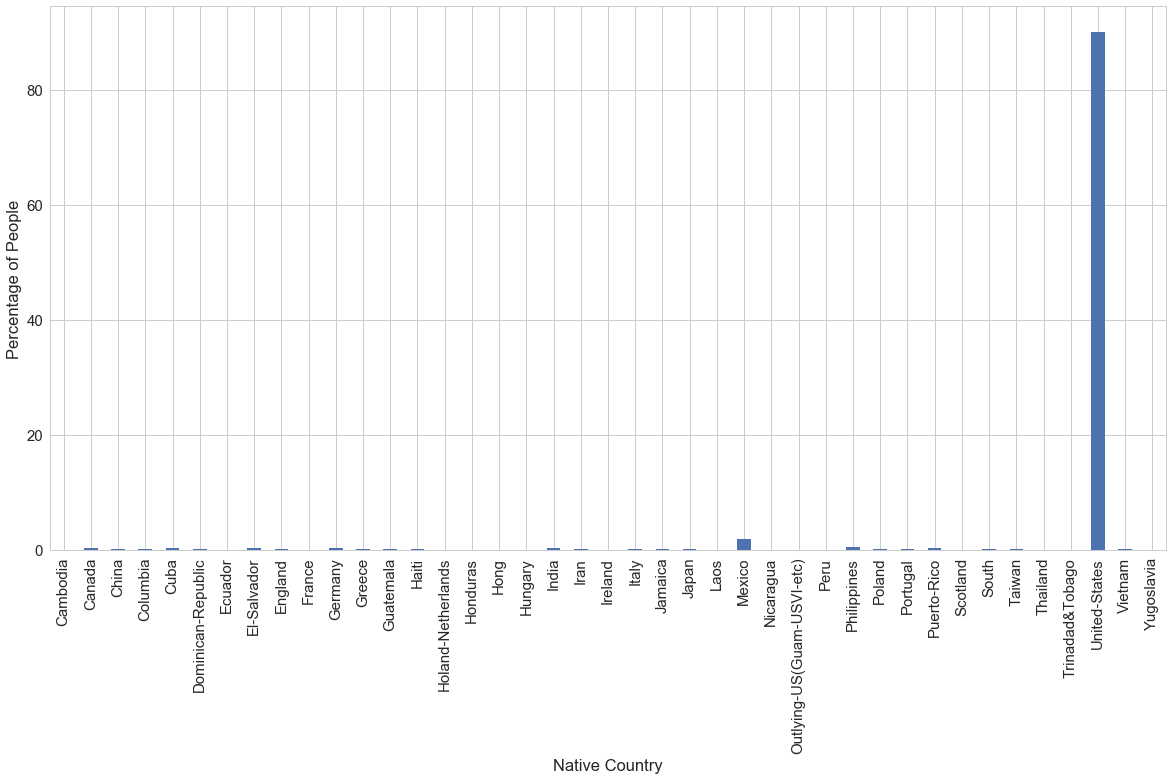

In [37]:
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = (df.groupby('NativeCountry').size() * 100 / len(df)).plot(kind='bar')
ax.set_ylabel("Percentage of People")
ax.set_xlabel("Native Country")
plt.show()

As we can see from this graph that **~89%** people belong to United states. So it is a good assumption to assign United states as the native country for users where is **NativeCountry** is **NaN**.

In [38]:
df["NativeCountry"] = df["NativeCountry"].fillna('United-States')

df["NativeCountry"].unique()

array(['United-States', 'Outlying-US(Guam-USVI-etc)', 'Mexico',
       'El-Salvador', 'Taiwan', 'Haiti', 'Cuba', 'Philippines',
       'Puerto-Rico', 'Japan', 'Thailand', 'Hungary', 'France', 'Columbia',
       'India', 'Jamaica', 'Germany', 'Peru', 'Canada', 'Hong', 'Italy',
       'Honduras', 'Poland', 'Ecuador', 'Ireland', 'Cambodia', 'Guatemala',
       'Dominican-Republic', 'Greece', 'Nicaragua', 'Iran', 'Vietnam',
       'Trinadad&Tobago', 'China', 'South', 'England', 'Yugoslavia',
       'Portugal', 'Laos', 'Scotland', 'Holand-Netherlands'], dtype=object)

### Handling Nan Values in 'WorkClass' Column 

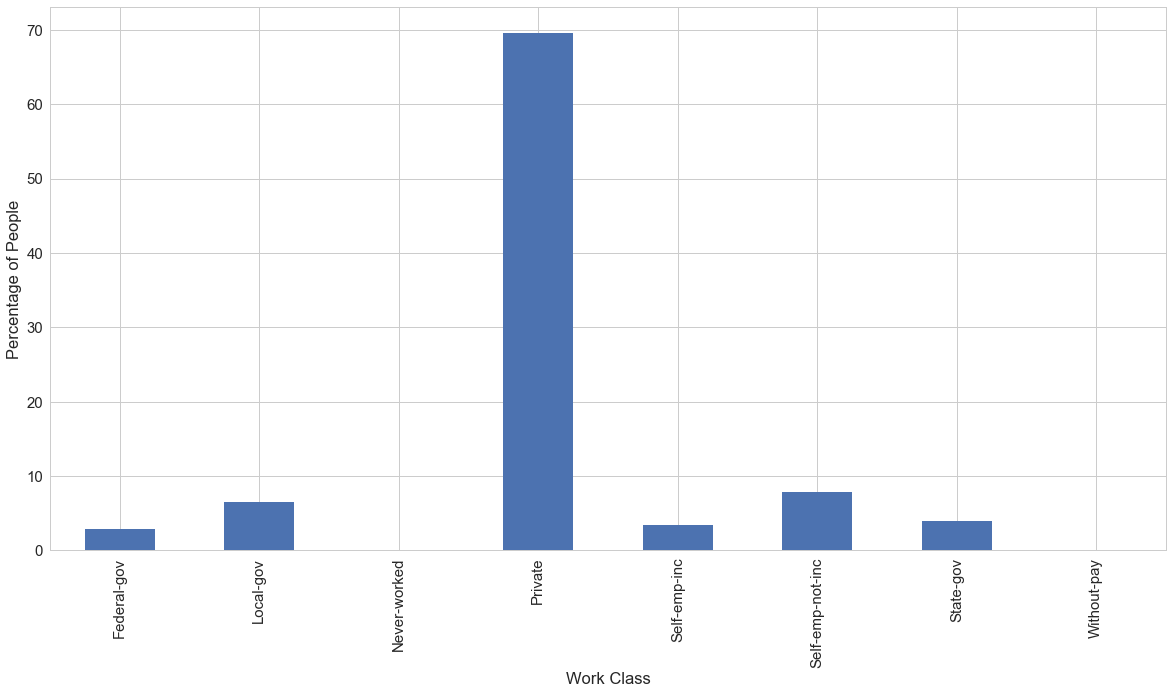

In [39]:
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = (df.groupby('WorkClass').size() * 100 / len(df)).plot(kind='bar')
ax.set_ylabel("Percentage of People")
ax.set_xlabel("Work Class")
plt.show()

As we can see from this graph that ~70% people belong to **Private** sector. So it is a good assumption to assign Private as the workclass in place of the Nan values.

In [40]:
df["WorkClass"] = df["WorkClass"].fillna('Private')

df["WorkClass"].unique()

array(['State-gov', 'Private', 'Self-emp-not-inc', 'Self-emp-inc',
       'Federal-gov', 'Local-gov', 'Never-worked', 'Without-pay'], dtype=object)

### Handling Nan Values in 'Occupation' Column 

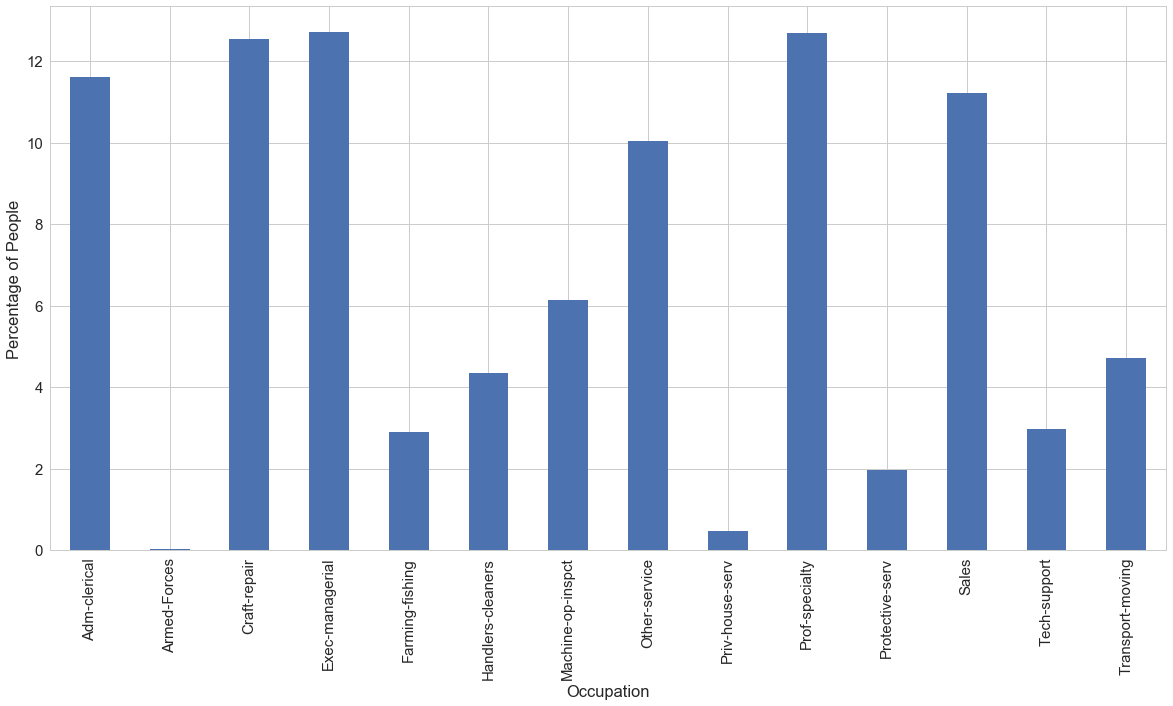

In [41]:
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = (df.groupby('Occupation').size() * 100 / len(df)).plot(kind='bar')
ax.set_ylabel("Percentage of People")
ax.set_xlabel("Occupation")
plt.show()

It is very difficult to comment anything for the **Occupation** column so we will try to combine 'WorkClass','Occupation' and see if we can find any conclusion. 

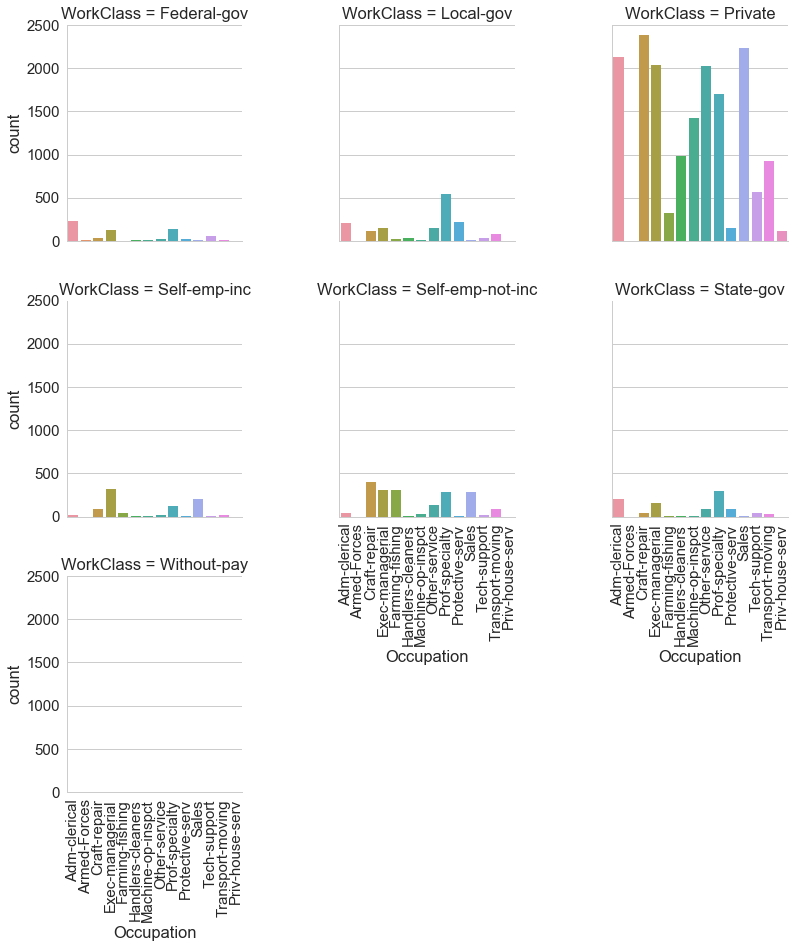

In [42]:
data = df.groupby(['WorkClass','Occupation']).size().to_frame('count').reset_index()
g = sns.factorplot(x="Occupation", y="count", col="WorkClass", data=data, kind="bar", col_wrap=3)
g.set_xticklabels(rotation=90)
plt.show()

It is still not very clear about the distribution for the NaN values, in this case, we will just drop all the rows with NaN values in order to improve the performance of the model.

#### drop NaN values from Occupation Column

In [43]:
df = df[df['Occupation'].notnull()]
df["Occupation"].unique()

array(['Farming-fishing', 'Other-service', 'Transport-moving',
       'Craft-repair', 'Sales', 'Adm-clerical', 'Exec-managerial',
       'Tech-support', 'Machine-op-inspct', 'Handlers-cleaners',
       'Protective-serv', 'Prof-specialty', 'Priv-house-serv',
       'Armed-Forces'], dtype=object)

In [44]:
# finally 23031 rows are remaining.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23031 entries, 0 to 24420
Data columns (total 15 columns):
Age              23031 non-null int64
WorkClass        23031 non-null object
FinalWeight      23031 non-null int64
Education        23031 non-null object
EducationLvl     23031 non-null int64
MaritalStatus    23031 non-null object
Occupation       23031 non-null object
Relationship     23031 non-null object
Race             23031 non-null object
Sex              23031 non-null object
CapitalGain      23031 non-null int64
CapitalLoss      23031 non-null int64
HoursPerWeek     23031 non-null int64
NativeCountry    23031 non-null object
IncomeBracket    23031 non-null object
dtypes: int64(6), object(9)
memory usage: 2.8+ MB


#### Encode Categorical columns

Lets first try to visualize the number of unique values in each of the categorical variables.

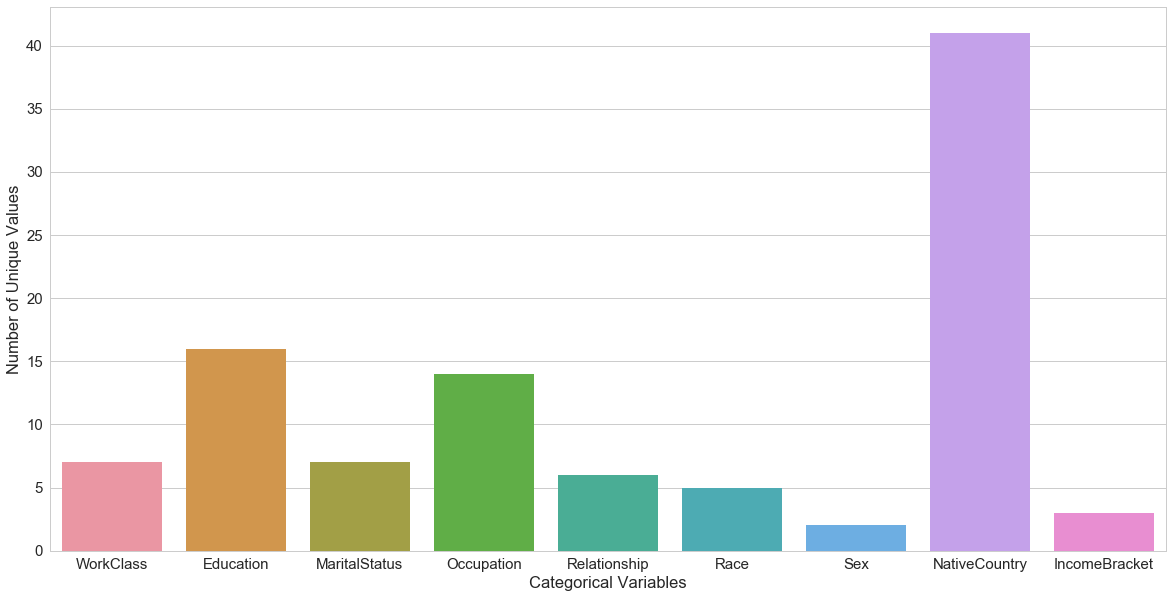

In [45]:
cd = []
for c in df.select_dtypes(include=['object']).columns:
    cd.append({
        'column': c,
        'values': len(df[c].unique())
    })

cd = pd.DataFrame(cd)
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
ax = sns.barplot(x="column", y="values", data=cd)
ax.set_ylabel("Number of Unique Values")
ax.set_xlabel("Categorical Variables")
plt.show()


#### How to Convert Categorical Data to Numerical Data?

This can be done by using one of the methods:

1. **Integer Encoding:** In this method, each unique category value is assigned an integer value.  For example, “red” is 1, “green” is 2, and “blue” is 3. This method is good when variables have ordered relationship between each other. For eq. Education has ordinal relationship as '12th' > 'Preschool'.

2. **One-Hot Encoding:** For categorical variables where no such ordinal relationship exists, the integer encoding is not enough. In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value. For example, in the “sex” variable, there are 2 categories and therefore 2 binary variables are needed. A “1” value is placed in the binary variable for the male and “0” values for the female.

#### Based on the above definition, we can perform the following operations. 

**One-Hot Encoding** on following columns as they are ordinally independent.
1. WorkClass
2. NativeCountry
3. MaritalStatus
4. Occupation
5. Relationship
6. Race
7. Sex

**Integer Encoding** on following columns as they are ordinally dependent.
1. IncomeBracket
2. Education


Source: 
1. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
2. https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/

In [46]:
# perform on hot encoding
df2 = pd.get_dummies(df, columns=['WorkClass', 'NativeCountry', 'MaritalStatus', 'Occupation', 'Relationship', 'Race','Sex'])

# debug
df2.head()

,Age,FinalWeight,Education,EducationLvl,CapitalGain,CapitalLoss,HoursPerWeek,IncomeBracket,WorkClass_Federal-gov,WorkClass_Local-gov,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male
0,42,179151,Some-college,10,0,0,40,<50K,0,0,...,0,0,0,0,0,0,0,1,0,1
1,28,68021,Some-college,10,0,0,30,<50K,0,0,...,0,0,0,0,0,0,0,1,1,0
2,24,233499,Some-college,10,0,0,40,50-100K,0,0,...,0,0,0,0,0,0,0,1,0,1
3,32,168782,9th,5,0,0,32,<50K,0,0,...,0,0,0,0,0,0,0,1,0,1
4,55,105582,Masters,14,2228,0,50,<50K,0,0,...,0,0,0,0,0,0,0,1,0,1


In [47]:
# perform integer encoding
cleanup_nums = {
    "IncomeBracket": {
        "<50K": 1, 
        "50-100K": 2,
        ">100K": 3
    },
    "Education": {
        "Doctorate" : 16,
        "Masters" : 15,
        "Bachelors" : 14,
        "Some-college" : 13,
        "Assoc-voc" : 12,
        "Assoc-acdm" : 11,
        "Prof-school" : 10,
        "HS-grad" : 9,
        "12th" : 8,
        "11th" : 7,
        "10th" : 6,
        "9th" : 5,
        "7th-8th" : 4,
        "5th-6th" : 3,
        "1st-4th" : 2,
        "Preschool": 1
    }
}

# remove categories with numbers
df2 = df2.replace(cleanup_nums)

# debug
df2.head()

,Age,FinalWeight,Education,EducationLvl,CapitalGain,CapitalLoss,HoursPerWeek,IncomeBracket,WorkClass_Federal-gov,WorkClass_Local-gov,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male
0,42,179151,13,10,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,28,68021,13,10,0,0,30,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,24,233499,13,10,0,0,40,2,0,0,...,0,0,0,0,0,0,0,1,0,1
3,32,168782,5,5,0,0,32,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,55,105582,15,14,2228,0,50,1,0,0,...,0,0,0,0,0,0,0,1,0,1


Here is the final dataframe after removing **NaN values** and **encoding categorical data** using one-hot and integer encoding.

## Part 2. Exploratory data analysis

In [48]:
df.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


#### Part A.  3 graphical figures that represent trends in the data

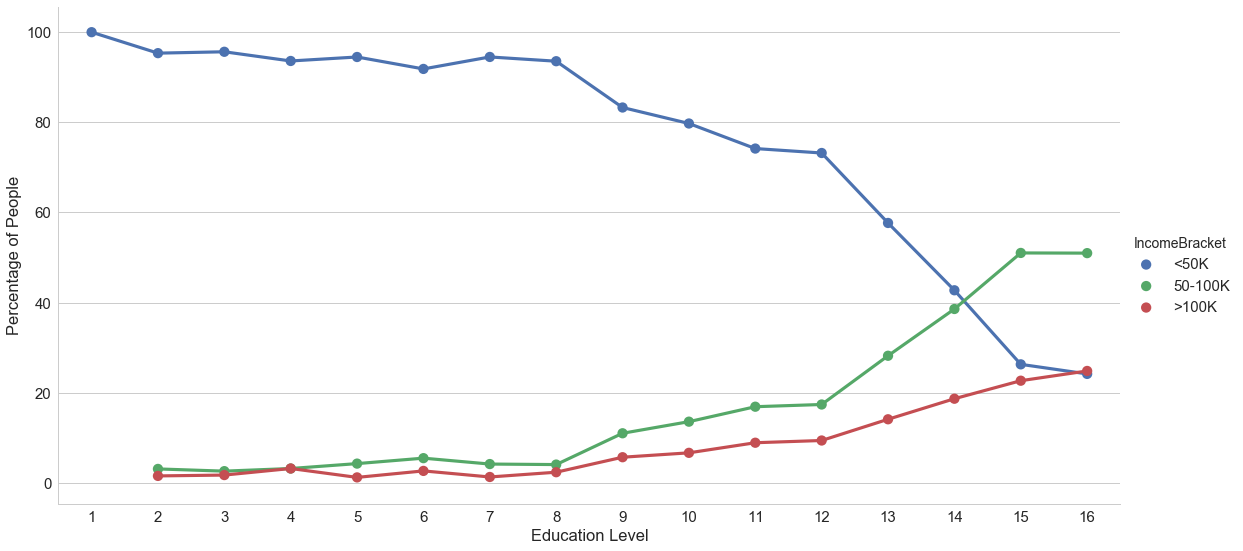

In [49]:
# graph 1
data = (df.groupby(['EducationLvl','IncomeBracket']).size() * 100 / df.groupby(['EducationLvl']).size()).to_frame('percentage').reset_index()
sns.factorplot(x="EducationLvl", y="percentage", hue="IncomeBracket", data=data, size=8, aspect=2)
plt.xlabel("Education Level")
plt.ylabel("Percentage of People")
plt.show()

Trend showing effect of education level on income bracket. As education level increases, the percentage of people increases from lower income bracket to higher income bracket. 

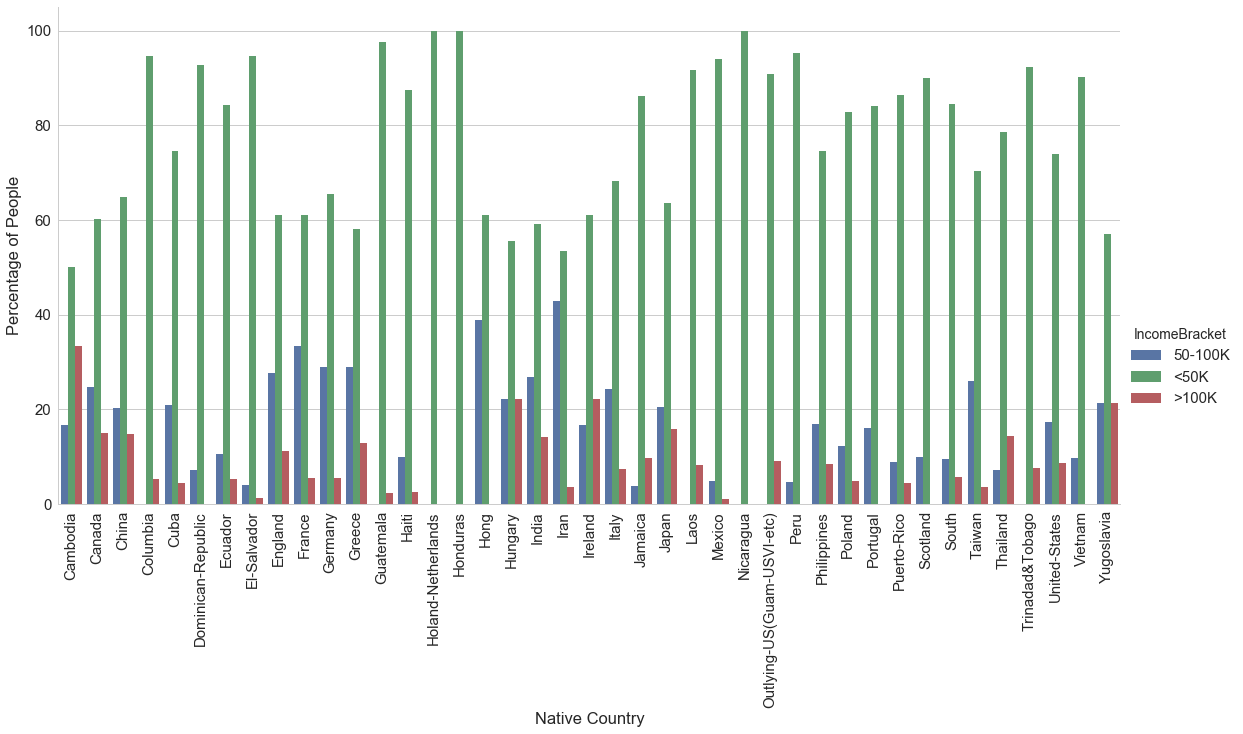

In [50]:
# graph 2
data = (df.groupby(['NativeCountry','IncomeBracket']).size() * 100 / df.groupby(['NativeCountry']).size()).to_frame('percentage').reset_index()
g = sns.factorplot(x="NativeCountry", y="percentage", hue="IncomeBracket", data=data, size=8, aspect=2, kind="bar")
g.set_xticklabels(rotation=90)
plt.xlabel("Native Country")
plt.ylabel("Percentage of People")
plt.show()

Graph 2 shows that in countries like Holand, Honduras and Nicaragua, most of the people lie in the lowest income bracket i.e. <50K. Combodia has the highest number of people earning greater than 100K. 

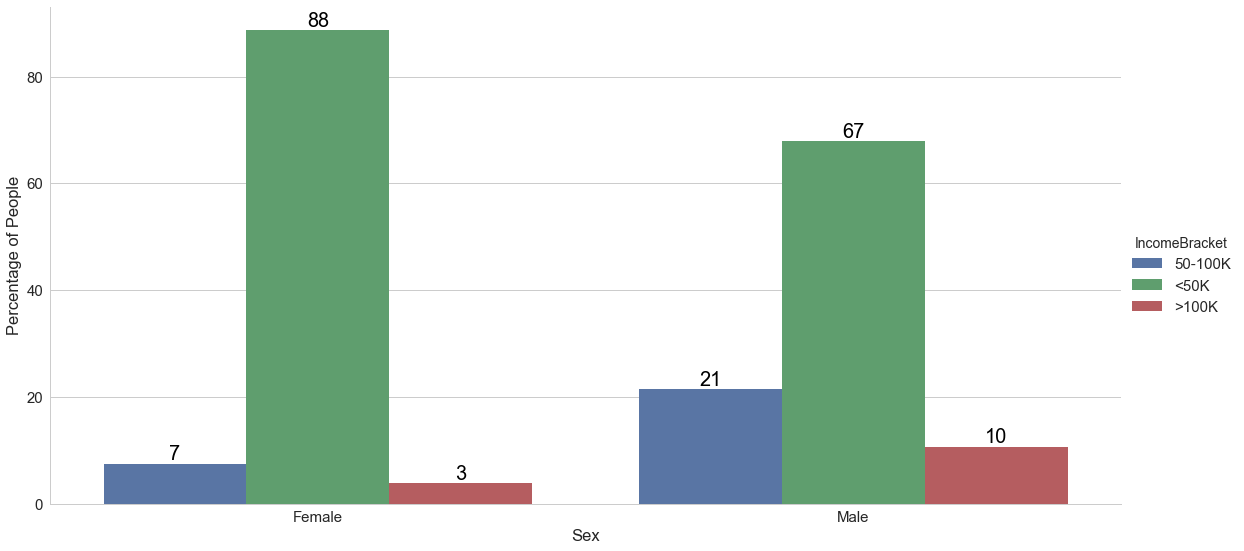

In [51]:
# graph 3
data = (df.groupby(['Sex','IncomeBracket']).size() * 100 / df.groupby(['Sex']).size()).to_frame('percentage').reset_index()
sns.factorplot(x="Sex", y="percentage", hue="IncomeBracket", data=data, size=8, aspect=2, kind='bar')
plt.xlabel("Sex")
plt.ylabel("Percentage of People")

# Iterate through the list of axes' patches
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=20, color='black', ha='center', va='bottom')

Graph 3 shows that the around 88% Females are in low income bracket (i.e. < 50K) and only 3% women are earning more than 100K whereas this number is equivalent to 10% for men. This shows a huge disparity of income between  different genders. 

#### Part B. Visualize the order of feature importance

In this section, we will try to visualize the feature importance. The steps followed in this section are:
1. use label encoder to encode categorical variables. (This is different from what we will be using in the later sections)
2. remove education column as it is same as educationlvl column.
3. plot correlation plot.


In [52]:
# import label encoder
from sklearn import preprocessing 

# convert labels using LabelEncoder just for feature importance evaluation
df3 = df.apply(preprocessing.LabelEncoder().fit_transform)

# remove education column as it is same as educationlvl
df3 = df3.drop('Education', axis=1)

#debug
df3.head()

,Age,WorkClass,FinalWeight,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,25,5,8071,9,2,4,0,4,1,0,0,39,38,1
1,11,2,1728,9,4,7,1,4,0,0,0,29,38,1
2,7,2,11789,9,2,13,0,4,1,0,0,39,38,0
3,15,4,7177,4,2,2,0,4,1,0,0,31,38,1
4,38,4,3291,13,2,11,0,4,1,27,0,49,38,1


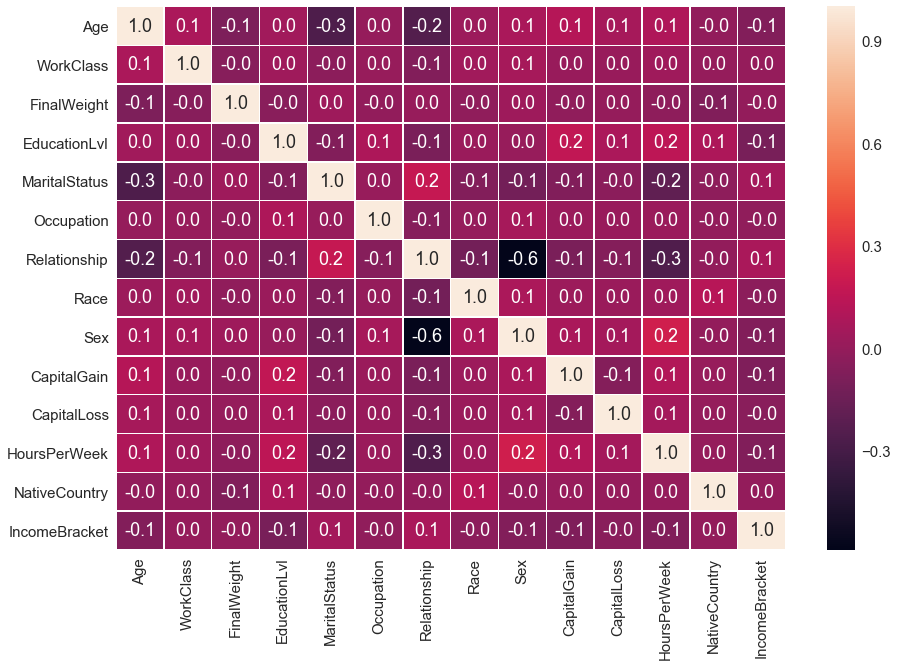

In [53]:
# Compute the correlation matrix  
corr_all = df3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (15, 10))

# Draw the heatmap with the mask and correct aspect ratio  
sns.heatmap(corr_all, annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

#### Discussion

It can be seen from the correlation plot that 'age', 'educationlvl', 'Sex', 'Capitalgain' are  correlated to income bracket. But still it is very hard to comment anything on the nature of the features and we would not be able to remove any feature using above information.


## Part 3. Feature selection

#### Steps:

1. Add **CapitalGain** and **CapitalLoss** and make a column called **'NetCapital'**
2. Remove Columns: **CapitalGain, CapitalLoss**
3. Remove column **'Education'** as it is repetitive after encoding.

#### Why feature selection is important?

The features in the data directly influence the predictive models we want to use and ultimately the results we are trying to achieve. In short,

1. Better features means flexibility
2. Better features means simpler models
3. Better features means better results

Reference: https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/


In [54]:
# add another column
df2['NetCapital'] = df2['CapitalLoss'] + df2['CapitalGain']

# remove columns
df2 = df2.drop(['CapitalLoss', 'CapitalGain', 'Education'],axis = 1 )

# debug
df2.columns

Index(['Age', 'FinalWeight', 'EducationLvl', 'HoursPerWeek', 'IncomeBracket',
       'WorkClass_Federal-gov', 'WorkClass_Local-gov', 'WorkClass_Private',
       'WorkClass_Self-emp-inc', 'WorkClass_Self-emp-not-inc',
       'WorkClass_State-gov', 'WorkClass_Without-pay',
       'NativeCountry_Cambodia', 'NativeCountry_Canada', 'NativeCountry_China',
       'NativeCountry_Columbia', 'NativeCountry_Cuba',
       'NativeCountry_Dominican-Republic', 'NativeCountry_Ecuador',
       'NativeCountry_El-Salvador', 'NativeCountry_England',
       'NativeCountry_France', 'NativeCountry_Germany', 'NativeCountry_Greece',
       'NativeCountry_Guatemala', 'NativeCountry_Haiti',
       'NativeCountry_Holand-Netherlands', 'NativeCountry_Honduras',
       'NativeCountry_Hong', 'NativeCountry_Hungary', 'NativeCountry_India',
       'NativeCountry_Iran', 'NativeCountry_Ireland', 'NativeCountry_Italy',
       'NativeCountry_Jamaica', 'NativeCountry_Japan', 'NativeCountry_Laos',
       'NativeCountry_Mexic

In [55]:
len(df2.columns)

88

#### Feature Extraction

There are **88** features in dataset but not all the features are equally important. For example, lets say, we have one categorical feature with 9 unique values. if we perform one hot encoding onto this feature then we will have 9 different features/dimension in our dataset. But in reality, if we know the values of 8 dimensions then we can easily find the outcome of 9 feature.

For feature extraction, we will use **Recursive Feature Extraction Method**. Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. In this RFECV, we will not only find best features but we also find how many features do we need for best accuracy.

Source: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html 


In [56]:
# Then we will split the data into features (X) and label (y).
X = df2.drop('IncomeBracket',axis=1)
y = df2['IncomeBracket']

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Estimator used for feature extraction is **RandomForestClassfier**


In [57]:
# Create the RFE object and rank each pixel
clf_rf = RandomForestClassifier() 

In [58]:
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=clf_rf, step=1, cv=10,scoring='accuracy')   #10-fold cross-validation

# fit model
rfecv = rfecv.fit(x_train, y_train)

#debug
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])
mainCols = x_train.columns[rfecv.support_]

Optimal number of features : 56
Best features : Index(['Age', 'FinalWeight', 'EducationLvl', 'HoursPerWeek',
       'WorkClass_Federal-gov', 'WorkClass_Local-gov', 'WorkClass_Private',
       'WorkClass_Self-emp-inc', 'WorkClass_Self-emp-not-inc',
       'WorkClass_State-gov', 'NativeCountry_Canada', 'NativeCountry_China',
       'NativeCountry_Cuba', 'NativeCountry_England', 'NativeCountry_Germany',
       'NativeCountry_Greece', 'NativeCountry_India', 'NativeCountry_Iran',
       'NativeCountry_Japan', 'NativeCountry_Mexico',
       'NativeCountry_Philippines', 'NativeCountry_Puerto-Rico',
       'NativeCountry_United-States', 'NativeCountry_Yugoslavia',
       'MaritalStatus_Divorced', 'MaritalStatus_Married-civ-spouse',
       'MaritalStatus_Married-spouse-absent', 'MaritalStatus_Never-married',
       'MaritalStatus_Separated', 'MaritalStatus_Widowed',
       'Occupation_Adm-clerical', 'Occupation_Craft-repair',
       'Occupation_Exec-managerial', 'Occupation_Farming-fishing',
  

Select columns which are present in mainCols variable.

In [59]:
# drop columns and Then we will split the data into features (X) and label (y).
y = df2['IncomeBracket']
X = df2.drop('IncomeBracket',axis=1)
X = X[mainCols]

# debug
X.head()

,Age,FinalWeight,EducationLvl,HoursPerWeek,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,WorkClass_State-gov,...,Relationship_Unmarried,Relationship_Wife,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male,NetCapital
0,42,179151,10,40,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,28,68021,10,30,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,24,233499,10,40,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,32,168782,5,32,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4,55,105582,14,50,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,2228


#### Discussion

Column 'NetCapital' added by combining CaptialGain & CapitalLoss'. Feature extraction was performed using Recursive Feature Extraction method with RandomForestClassifier as the estimator using 10 fold cross validation. Features were selected based on their importance using RFECV.

## Part 4. Model implementation

We are using 4 different classification techniques with 10 fold validation in the analysis:
1. Random Forest Classifier
2. Logistic Regression
3. Decision Tree Classifier
4. K Neighbors Classifier

### Logistic Regression
It is a technique that classifies into multiple classess using a logistic/sigmoid function.

**Pros**
- Convenient probability scores for observations
- Efficient implementations available across tools
- Multi-collinearity is not really an issue and can be countered with L2 regularization to an extent

**Cons**
- Doesn’t perform well when feature space is too large
- Doesn’t handle large number of categorical features/variables well
- Relies on transformations for non-linear features

### Random Forest Classifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

**Pros**
- Decorrelates trees
- important when dealing with mulitple features which may be correlated
- reduced variance (relative to regular trees)

**Cons**
- Not as easy to visually interpret

### Decision Tree Classifier
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

**Pros**
- easy to interpret visually when the trees only contain several levels
- Can easily handle qualitative (categorical) features
- Works well with decision boundaries parellel to the feature axis

**Cons**
- prone to overfitting
- possible issues with diagonal decision boundaries

### K Nearest Neighbour
In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non- parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space.

**Pros**
- Simple to implement
- Flexible to feature / distance choices
- Naturally handles multi-class cases
- Can do well in practice with enough representative data

**Cons**
- Large search problem to find nearest neighbours
- Storage of data
- Must know we have a meaningful distance function

The algorithms were chosen based on their simplicity and application to the industry. [Article](https://www.dezyre.com/article/top-10-machine-learning-algorithms/202) has mentioned couple of commonly used algos for classfication and randomly 4 were chosen for analysis.


In [60]:
# define 4 different models
rfc = RandomForestClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier()
gbc = GradientBoostingClassifier()

In [125]:
def modelPredict(model, fold, X_train, y_train, X_test, y_test, algo, res):
    
    # fit
    model.fit(X_train, y_train) 
    
    # accuracy 
    accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # store/append
    res.append({
        'algo': algo,
        'fold': fold,
        'type': 'train',
        'accuracy': accuracy_score(y_train, model.predict(X_train))
    })
    res.append({
        'algo': algo,
        'fold': fold,
        'type': 'test',
        'accuracy': accuracy_score(y_test, model.predict(X_test))
    })
    
    # return
    return res


#run KFold with 10 folds instead of the default 3
kf = KFold(len(X), n_folds=10)
res = []
fold = 0

for train_index, test_index in kf:
    
    # fold index
    fold += 1
    
    # data
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    #model 1:  
    res = modelPredict(rfc, fold, X_train, y_train, X_test, y_test, 'Random Forest', res)
    
    #model 2: 
    res = modelPredict(lr, fold, X_train, y_train, X_test, y_test, 'Logestic Regression', res)
    
    #model 3:
    res = modelPredict(dtc, fold, X_train, y_train, X_test, y_test, 'Decision Tree', res)
    
    #model 4: 
    res = modelPredict(knn, fold, X_train, y_train, X_test, y_test, 'K Nearest Neighbor', res)
    
    #model 5: 
    res = modelPredict(gbc, fold, X_train, y_train, X_test, y_test, 'Gradient Boosting', res)


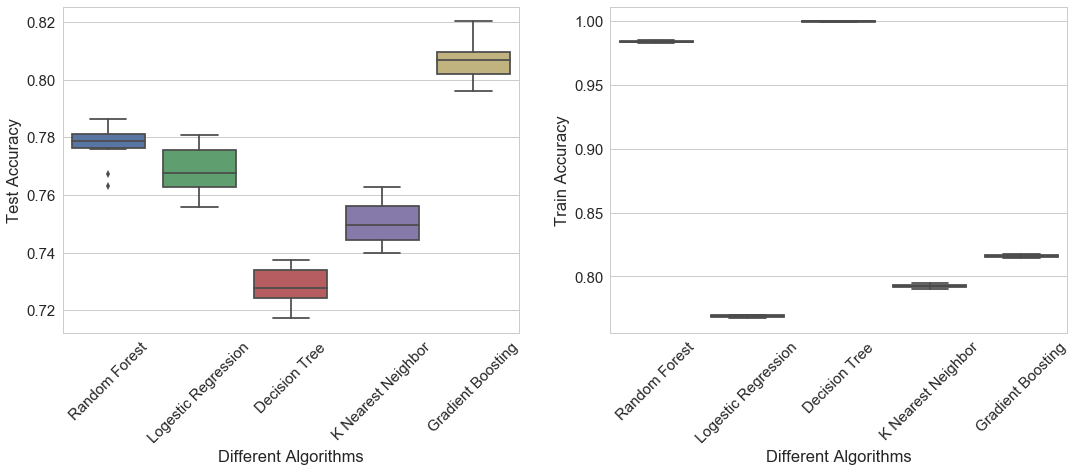

In [126]:
fig, ax = plt.subplots(1,2, figsize = (18, 6))
res = pd.DataFrame(res)
g2 = sns.boxplot(x="algo", y="accuracy", data=res[res['type'] == 'test'], ax=ax[0])
g2.set_xlabel('Different Algorithms')
g2.set_ylabel('Test Accuracy')
g1 = sns.boxplot(x="algo", y="accuracy", data=res[res['type'] == 'train'], ax=ax[1])
plt.setp(g1.get_xticklabels(), rotation=45)
plt.setp(g2.get_xticklabels(), rotation=45)
g1.set_xlabel('Different Algorithms')
g1.set_ylabel('Train Accuracy')
plt.show()

In [127]:
r = pd.pivot_table(res,index=["algo", "type"],values=["accuracy"],aggfunc=[np.mean,np.var]).reset_index()
r.columns = ['algorithm', 'type', 'mean', 'variance']
r

,algorithm,type,mean,variance
0,Decision Tree,test,0.731709,5.050691e-05
1,Decision Tree,train,0.999841,1.060272e-09
2,Gradient Boosting,test,0.807129,5.506477e-05
3,Gradient Boosting,train,0.816079,8.045967e-07
4,K Nearest Neighbor,test,0.750293,5.847445e-05
5,K Nearest Neighbor,train,0.792430,1.174471e-06
6,Logestic Regression,test,0.768877,7.253847e-05
7,Logestic Regression,train,0.768795,9.127596e-07
8,Random Forest,test,0.780123,6.387255e-05
9,Random Forest,train,0.982917,5.567930e-07


From the above graphs, it can be stated that ***Gradient Boosting Classifier*** has the best performance with accuracy of **~81%** on the test set. **Random Forest and Decision tree** classifiers are having a accuracy of more than **98%** on training set and less than **78%** on test set which means that these alogrithms have overfitting issues on the data. Other 3 algorithms, namely, **Logestic regression, KNN and Gradient Boosting** almost have similar accuracy for both test and train data. To improve the accuracy, we can further tune the hyperparameters of the respective algorithms. In terms of **Bias Variance Tradeoff**, Random Forest and decision tree classfiers have high bias due to their complexity of the algorithm ang hence overfitting the model by memorizing the data. 


## Part 5. Model tuning

In [117]:
def modelPredictGridSearchCV(model, X_train, y_train, X_test, y_test, algo, parameter):
    
    # Use classification accuracy to compare parameter combinations
    acc_scorer_model = make_scorer(accuracy_score)

    # Run a grid search for the Logistic Regression classifier and all the selected parameters
    grid_obj_model = GridSearchCV(model, parameter, scoring=acc_scorer_model, cv = 5)
    grid_obj_model = grid_obj_model.fit(X_train, y_train)

    # Set our classifier, lg, to have the best combination of parameters
    model = grid_obj_model.best_estimator_

    # fit
    model.fit(X_train, y_train)
    
    # predict
    predictions = model.predict(X_test)
    
    # accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    # return
    return {
        'algo': algo,
        'accuracy': accuracy,
        'bestParam': grid_obj_model.best_params_
    }

# results var
results = []

# split data train 70 % and test 30 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#model 1:
params = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
results.append(modelPredictGridSearchCV(rfc, X_train, y_train, X_test, y_test, 'Random Forest', params))

#model 2: 
params = {'C':[0.2, 0.4, 0.5, 0.6, 0.8]}
results.append(modelPredictGridSearchCV(lr, X_train, y_train, X_test, y_test, 'Logestic Regression', params))

#model 3:
params = {'max_depth': np.arange(3, 15)}
results.append(modelPredictGridSearchCV(dtc, X_train, y_train, X_test, y_test, 'Decision Tree', params))

#model 4: 
params = {'n_neighbors': [3, 5, 8, 10, 15]}
results.append(modelPredictGridSearchCV(knn, X_train, y_train, X_test, y_test, 'K Nearest Neighbor', params))

#model 5: 
params = {'max_depth': [3, 5, 8, 10, 15, 20, 30]}
results.append(modelPredictGridSearchCV(gbc, X_train, y_train, X_test, y_test, 'Gradient Boosting', params))

In [119]:
results = pd.DataFrame(results)
results

,accuracy,algo,bestParam
0,0.785962,Random Forest,{'n_estimators': 100}
1,0.767438,Logestic Regression,{'C': 0.2}
2,0.794645,Decision Tree,{'max_depth': 5}
3,0.766281,K Nearest Neighbor,{'n_neighbors': 15}
4,0.806657,Gradient Boosting,{'max_depth': 3}


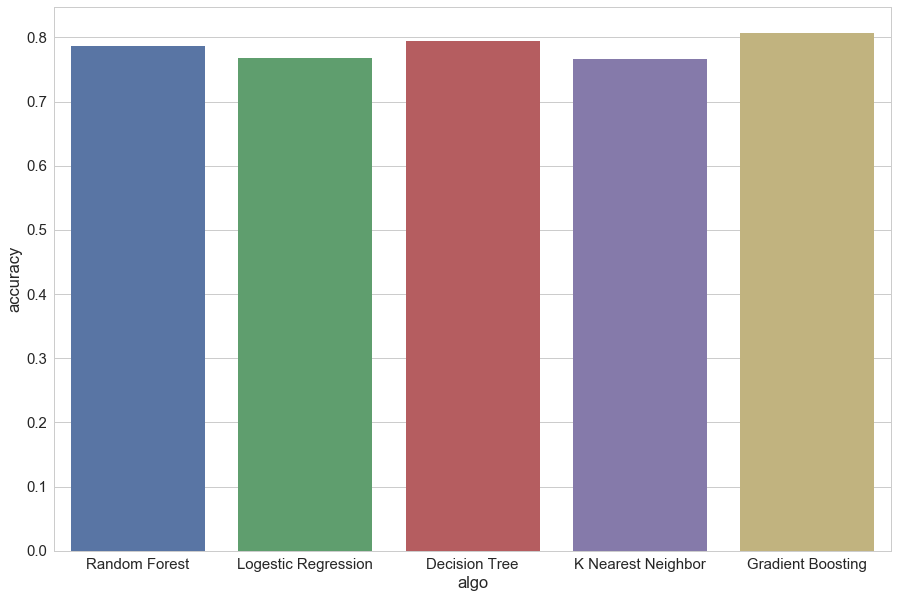

In [120]:
f, ax = plt.subplots(figsize = (15, 10))
sns.barplot(x="algo", y="accuracy", data=results)
plt.show()

#### Discussion

Hyperparameter tuning was performed for each of the 5 algorithms. For the sake of simplcity, only one param from each of the algorithm was tuned as summerized below:

1. Random Forest:  n_estimators (The number of trees in the forest)
2. Logestic Regression: C (Inverse of regularization strength)
3. Decision Tree: max_depth (The maximum depth of the tree)
4. K Nearest Neighbor: n_neighbors (Number of neighbors to use)
5. Gradient Boosting: max_depth (maximum depth of the individual regression estimators)

From above grid search analysis, we can say that **Gradient Boosting** has the best accuracy of ~81% on the test set. Hence, we will be using it on the test data. The chosen value for the param max_depth is **3**. Also, all the models have at least 70% accuracy in cross-validation.


## Part 6. Testing & Discussion


#### Prepare Testing Data


In [128]:
# get testing data
dfTest = pd.read_csv('income-testing.csv')

# handle nan values
dfTest["NativeCountry"] = dfTest["NativeCountry"].fillna('United-States')
dfTest["WorkClass"] = dfTest["WorkClass"].fillna('Private')
dfTest = dfTest[dfTest['Occupation'].notnull()]

# encode categories
dfTest = pd.get_dummies(dfTest, columns=['WorkClass', 'NativeCountry', 'MaritalStatus', 'Occupation', 'Relationship', 'Race','Sex'])
dfTest = dfTest.replace(cleanup_nums)

# add columns
dfTest['NetCapital'] = dfTest['CapitalLoss'] + dfTest['CapitalGain']
dfTest = dfTest.drop(['CapitalLoss', 'CapitalGain', 'Education'], axis = 1 )

#get columns based on feature extracion step
Y_TEST = dfTest['IncomeBracket']
dfTest = dfTest.drop('IncomeBracket',axis=1)
X_TEST = dfTest[mainCols]

#debug
X_TEST.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11521 entries, 0 to 12210
Data columns (total 56 columns):
Age                                    11521 non-null int64
FinalWeight                            11521 non-null int64
EducationLvl                           11521 non-null int64
HoursPerWeek                           11521 non-null int64
WorkClass_Federal-gov                  11521 non-null uint8
WorkClass_Local-gov                    11521 non-null uint8
WorkClass_Private                      11521 non-null uint8
WorkClass_Self-emp-inc                 11521 non-null uint8
WorkClass_Self-emp-not-inc             11521 non-null uint8
WorkClass_State-gov                    11521 non-null uint8
NativeCountry_Canada                   11521 non-null uint8
NativeCountry_China                    11521 non-null uint8
NativeCountry_Cuba                     11521 non-null uint8
NativeCountry_England                  11521 non-null uint8
NativeCountry_Germany                  11521 non-nu

#### Run model to find accuracy on test and train sets

In [129]:
# GradientBoostingClassifier 
dtc = GradientBoostingClassifier(max_depth=3)

# fit
dtc.fit(X, y)
    
# predict
trainPredictions = dtc.predict(X)
testPredictions = dtc.predict(X_TEST)

# accuracy
print("Train Accuracy: " + str(accuracy_score(y, trainPredictions)))
print("Test Accuracy: " + str(accuracy_score(Y_TEST, testPredictions)))

Train Accuracy: 0.81559637011
Test Accuracy: 0.799409773457


#### Discussion 

The optimal model chosen from the analysis was **Gradient Boosting** with value of max_depth equal to **3**. Using this model, predictions were made on the test set and train set and it was found that the accuracy is almost similar i.e. **81.6%** for train set and **80%** for the test set. It is performing slightly better for the train set which can be due to overfitting but it is very hard comment anything like that. We can conclude that it is neither overfitting nor underfitting. To inrcease the accuracy further for this model, we can tune other hyperparameters for Gradient Boosting Classifier.